In [615]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from scipy.stats import pointbiserialr


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from collections import Counter



import joblib


# 0- Importation du fichier merge preclean

In [616]:
df = pd.read_parquet(r'C:\Users\dimle\Documents\clone_repo\preventive_maintenance\data_preclean_avion.parquet')

In [617]:
pd.set_option("display.max_columns", None)

In [618]:
df.head(3)

,aero_,measure_day_,usure_nouvelle_max_Composants Critiques,usure_nouvelle_max_Composants Majeurs,usure_nouvelle_max_Composants Secondaires,usure_nouvelle_mean_Composants Critiques,usure_nouvelle_mean_Composants Majeurs,usure_nouvelle_mean_Composants Secondaires,time_en_air,etat_voyant,temp,pressure,vibrations,type_model,debut_service,last_maint,en_maintenance,measure_day,temps_de_vol_cumule
0,A320_1884,2024-06-04,61.126660,60.781740,59.684620,28.157460,32.796355,29.171363,9.8,0,4.3,907.3,1.763677,A320,2015-12-26,2024-06-01,False,2024-06-04,9.8
1,A320_1884,2024-06-05,62.128398,61.547122,60.747186,29.045238,33.699044,30.416709,7.4,1,-24.3,905.9,3.428686,A320,2015-12-26,2024-06-01,False,2024-06-05,7.4
2,A320_1884,2024-06-08,62.466823,61.805697,61.106161,29.345163,34.004007,30.837434,2.5,0,-8.4,962.5,1.290613,A320,2015-12-26,2024-06-01,False,2024-06-08,2.5


# 1- clean du dataset pour le ML

In [619]:
df['measure_day_'] = pd.to_datetime(df['measure_day_'])
df['last_maint'] = pd.to_datetime(df['last_maint'])

In [620]:
# ajouter la colonne nb de jour depuis la derniere maintenande
# measure_day_ - last_maint

df['nb_jours_maint'] = df.apply(lambda x: x['measure_day_'] - x['last_maint'], axis=1)

In [621]:
# ajout du nombre de jour depuis la mise en service à jour_vol
df['nb_jours_service'] = df.apply(lambda x: x['measure_day_'] - x['debut_service'], axis=1)

In [622]:
# suppression des colonnes date inutile
df = df.drop(columns=['measure_day', 'last_maint', 'debut_service'])

In [623]:
# modification du type de variable pour les ecarts de date (passage en integer depuis un timedelta64[ns] en jour)
df['nb_jours_maint'] = df['nb_jours_maint'].dt.days
df['nb_jours_service'] = df['nb_jours_service'].dt.days

In [624]:
df.head(2)

,aero_,measure_day_,usure_nouvelle_max_Composants Critiques,usure_nouvelle_max_Composants Majeurs,usure_nouvelle_max_Composants Secondaires,usure_nouvelle_mean_Composants Critiques,usure_nouvelle_mean_Composants Majeurs,usure_nouvelle_mean_Composants Secondaires,time_en_air,etat_voyant,temp,pressure,vibrations,type_model,en_maintenance,temps_de_vol_cumule,nb_jours_maint,nb_jours_service
0,A320_1884,2024-06-04,61.126660,60.781740,59.684620,28.157460,32.796355,29.171363,9.8,0,4.3,907.3,1.763677,A320,False,9.8,3,3083
1,A320_1884,2024-06-05,62.128398,61.547122,60.747186,29.045238,33.699044,30.416709,7.4,1,-24.3,905.9,3.428686,A320,False,7.4,4,3084


In [625]:
df.isna().sum()

aero_                                         0
measure_day_                                  0
usure_nouvelle_max_Composants Critiques       0
usure_nouvelle_max_Composants Majeurs         0
usure_nouvelle_max_Composants Secondaires     0
usure_nouvelle_mean_Composants Critiques      0
usure_nouvelle_mean_Composants Majeurs        0
usure_nouvelle_mean_Composants Secondaires    0
time_en_air                                   0
etat_voyant                                   0
temp                                          0
pressure                                      0
vibrations                                    0
type_model                                    0
en_maintenance                                0
temps_de_vol_cumule                           0
nb_jours_maint                                0
nb_jours_service                              0
dtype: int64

# 1.bis- Visualisation des data 

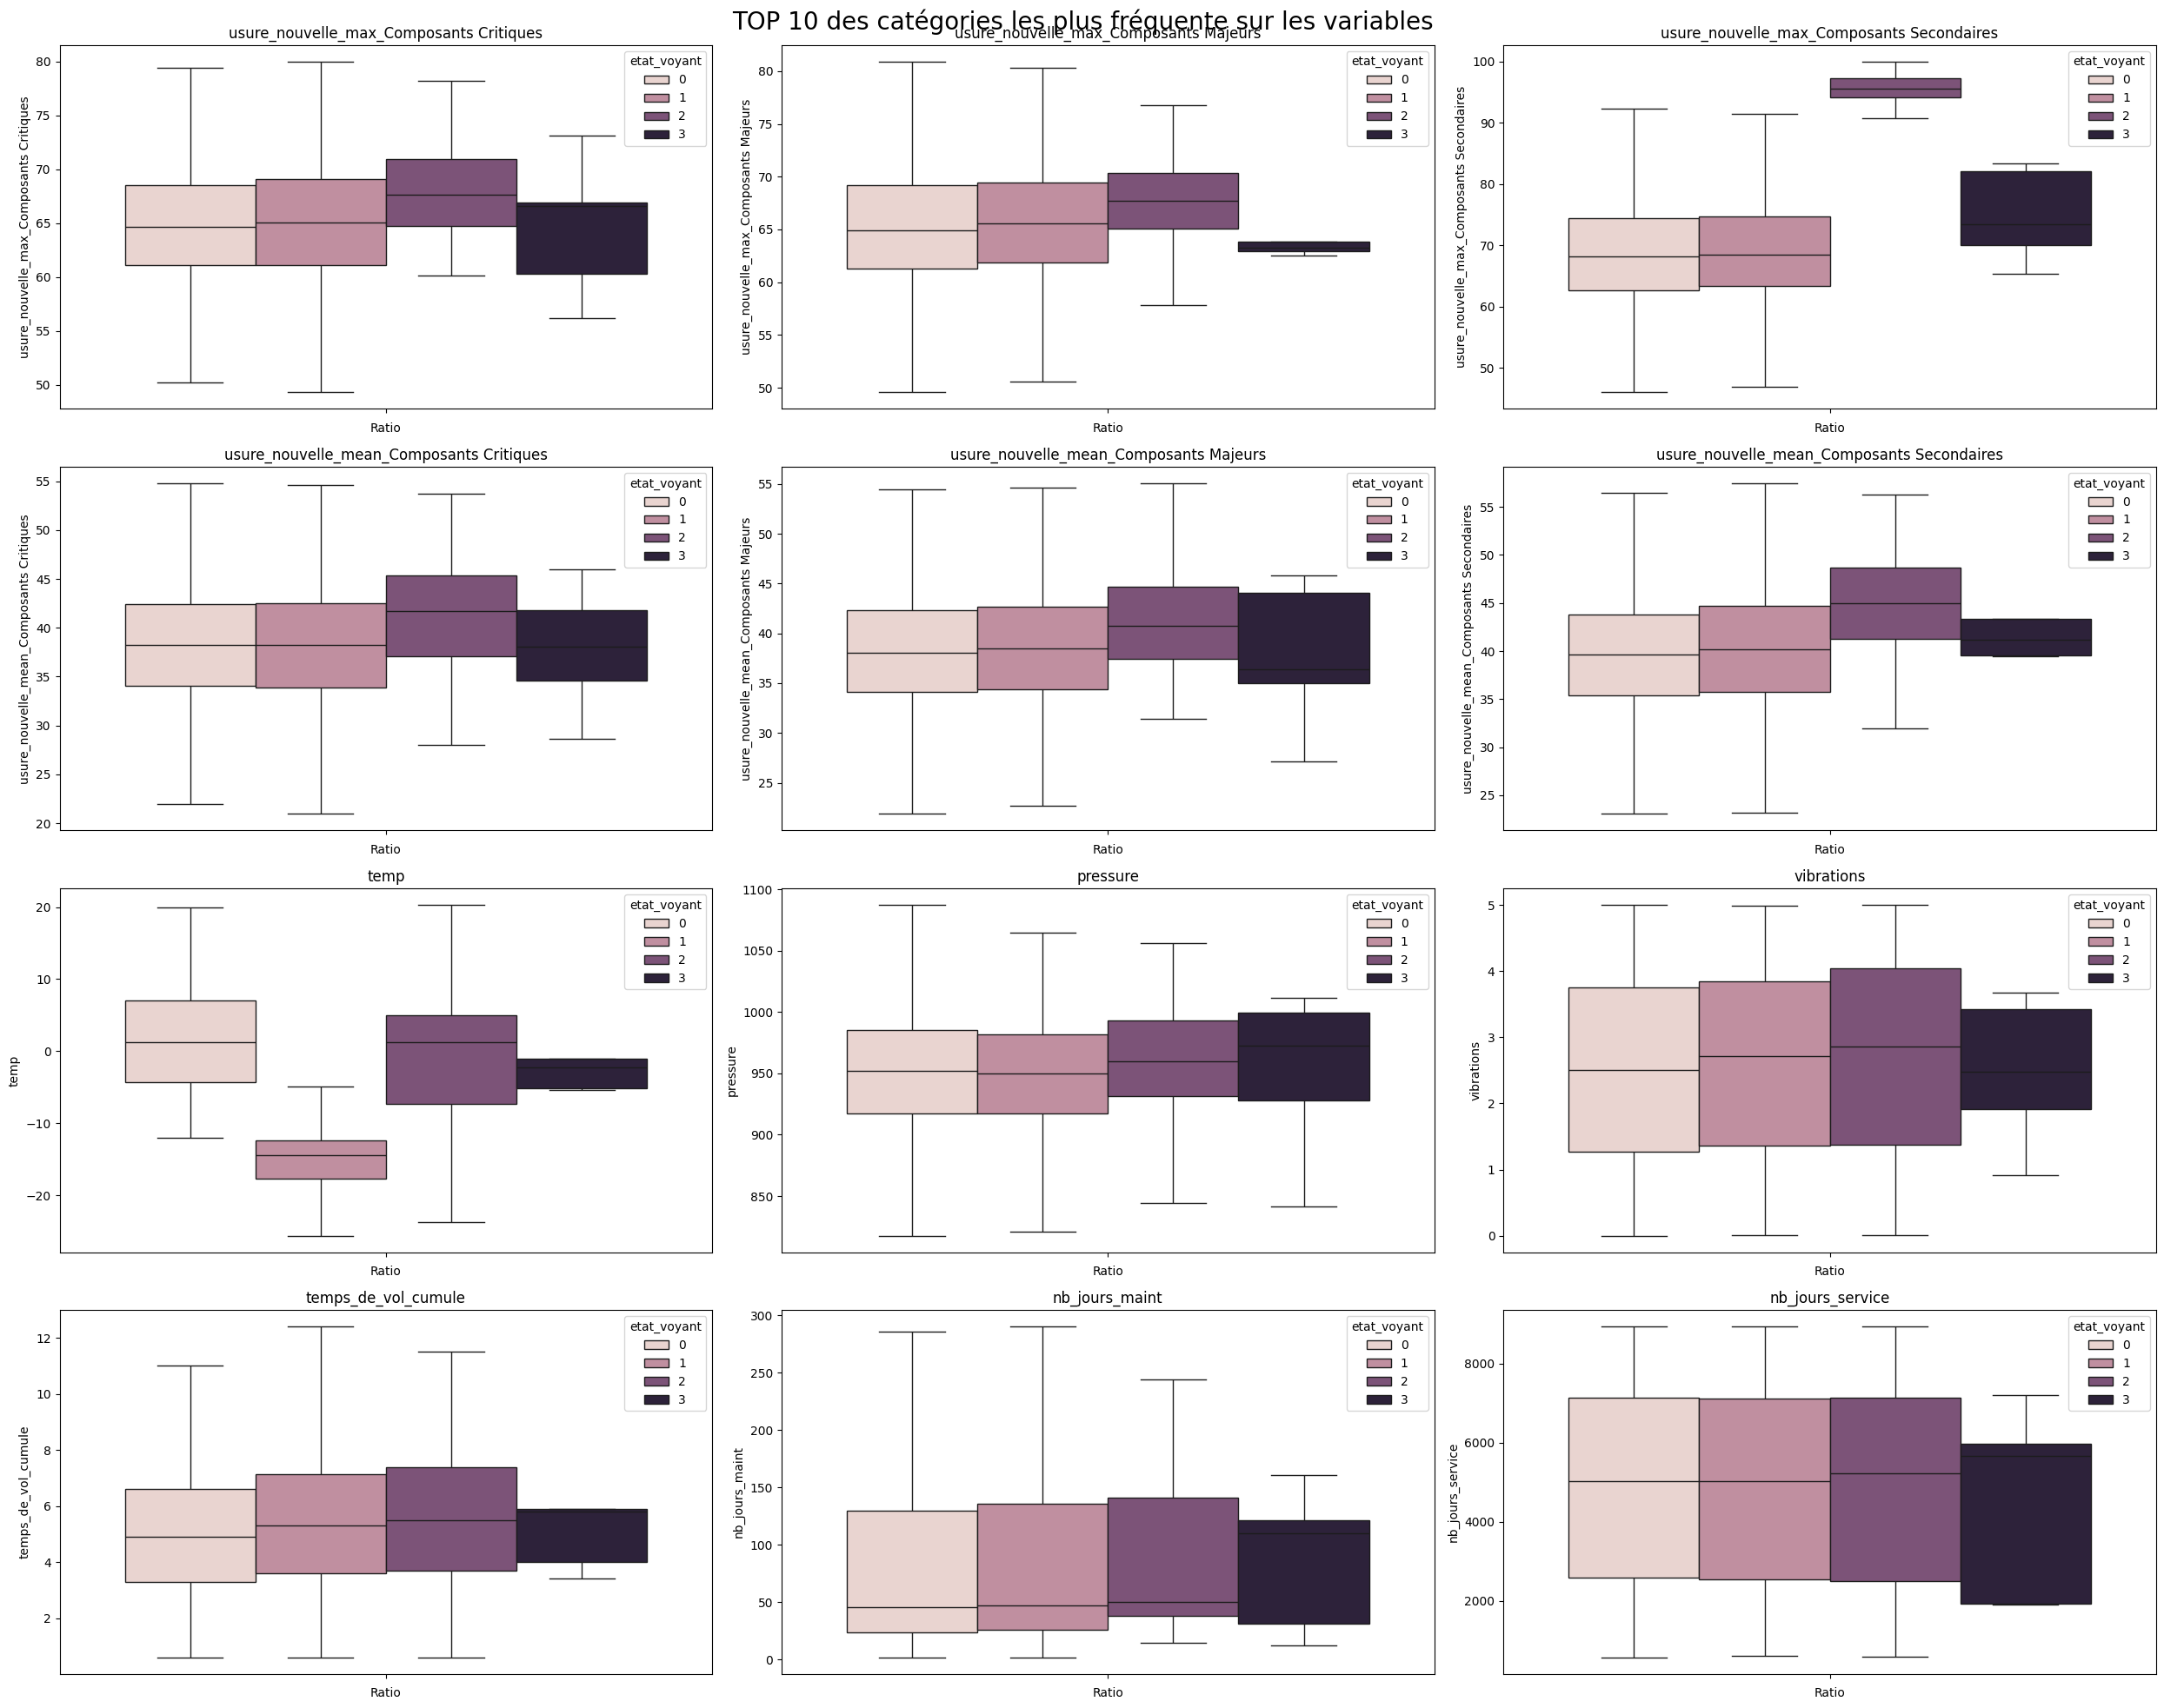

In [626]:
df_num = df[['usure_nouvelle_max_Composants Critiques',
       'usure_nouvelle_max_Composants Majeurs',
       'usure_nouvelle_max_Composants Secondaires',
       'usure_nouvelle_mean_Composants Critiques',
       'usure_nouvelle_mean_Composants Majeurs',
       'usure_nouvelle_mean_Composants Secondaires',
       'temp', 'pressure', 'vibrations',
       'temps_de_vol_cumule', 'nb_jours_maint',
       'nb_jours_service']]

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(4, 3, figsize=(25, 20))
fig.suptitle('TOP 10 des catégories les plus fréquente sur les variables', fontsize=20)
fig.tight_layout(pad=3.0)

# Parcourir chaque colonne et créer un histogramme
for i, col in enumerate(df_num.columns):
    

    sns.boxplot(data=df, y=col,  ax=axes[i//3, i%3], hue='etat_voyant', showfliers= False)
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].set_xlabel('Ratio')
    axes[i//3, i%3].set_ylabel(col)

plt.tight_layout()
plt.show()

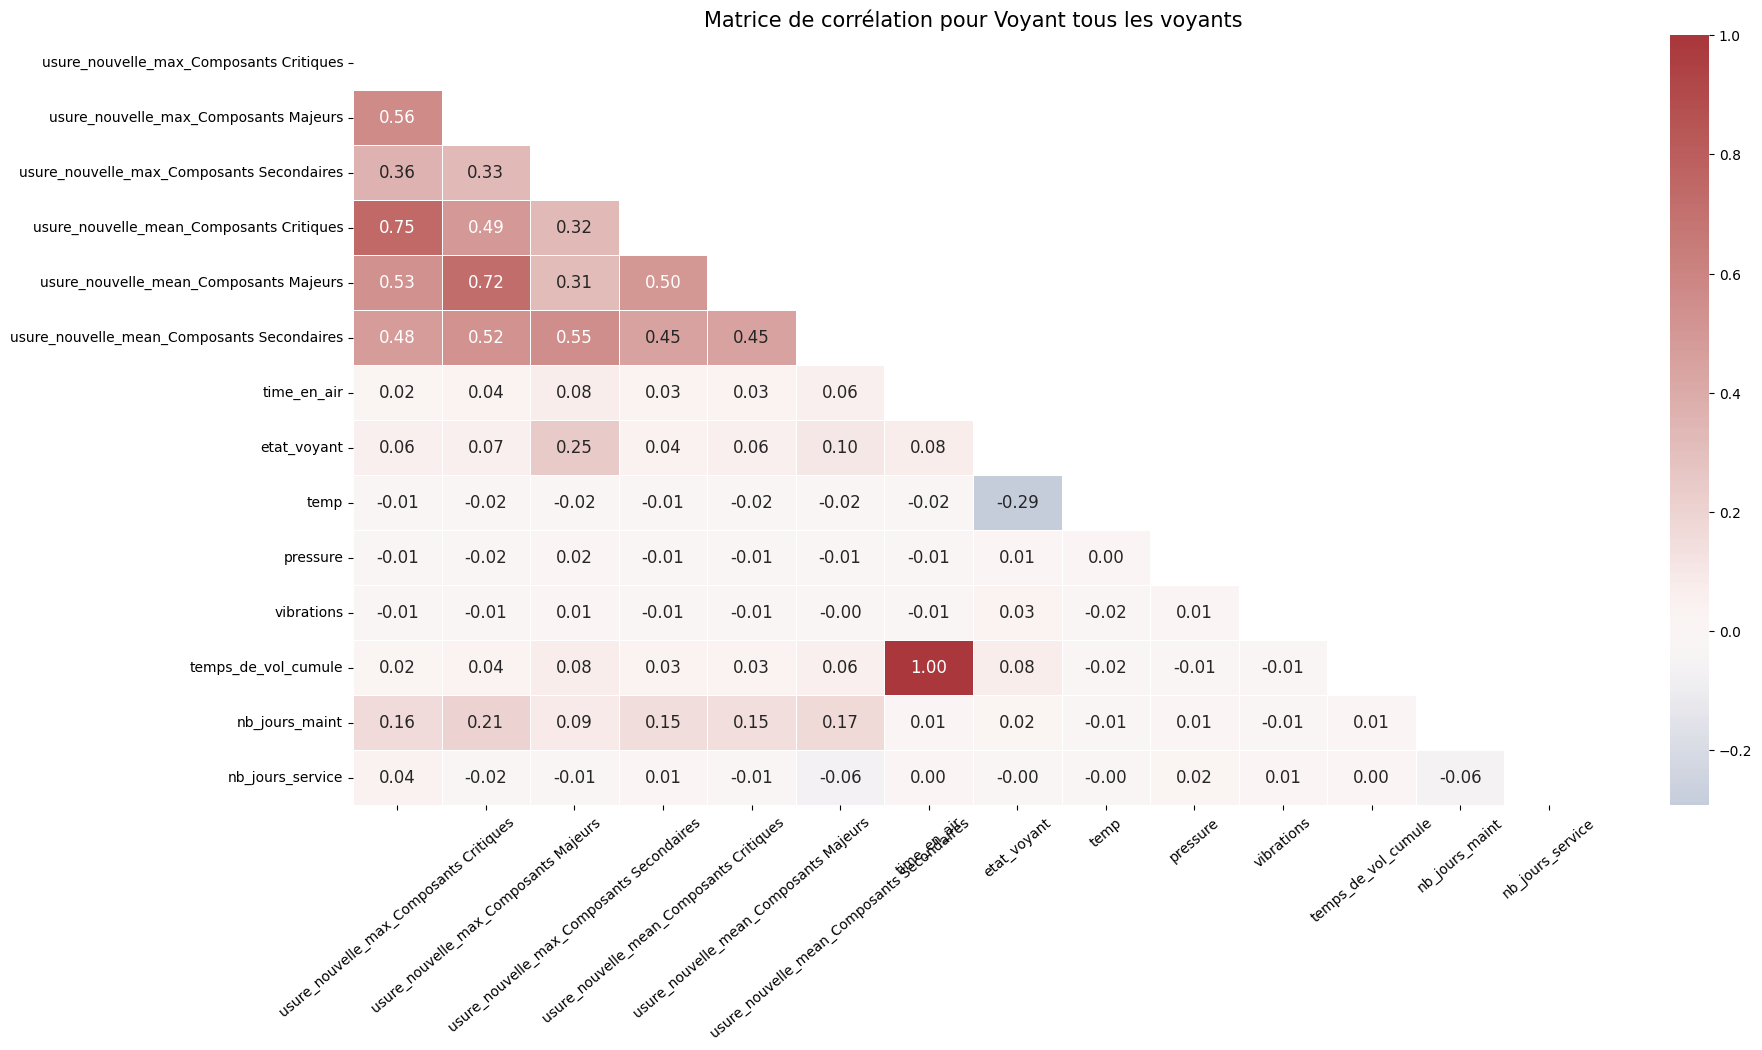

In [627]:
fig_correl, ax_correl = plt.subplots(1,1, figsize = (20,10))

numerical_corr_matrix = df.select_dtypes(include='number').corr()

mask = np.triu(np.ones_like(numerical_corr_matrix, dtype=bool))

annot_kwargs = {
    "fontsize": 12
}

sns.heatmap(numerical_corr_matrix,
                center= 0,
                cmap = sns.color_palette("vlag", as_cmap=True),
                annot= True,
                mask= mask,
                ax=ax_correl,
                linewidths=.5,
                fmt= '.2f',
                annot_kws= annot_kwargs
                )

ax_correl.set_title('Matrice de corrélation pour Voyant tous les voyants', fontsize= 15)
ax_correl.set_xticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 40)
ax_correl.set_yticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 0)

plt.show(fig_correl.figure)

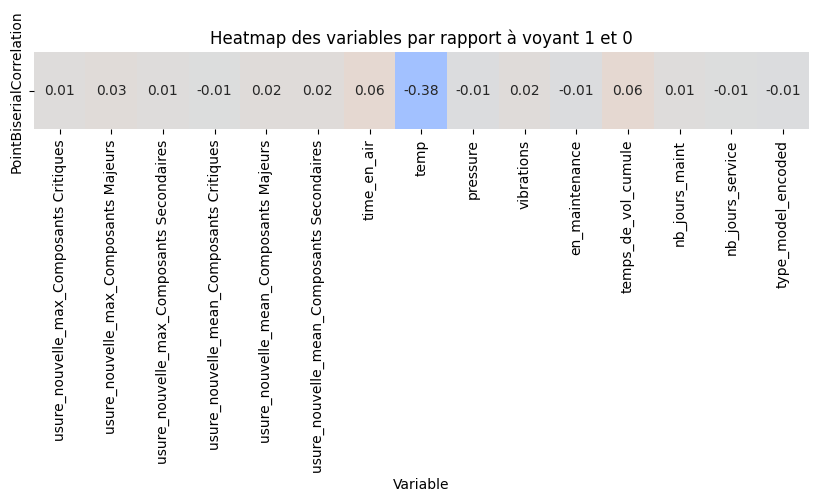

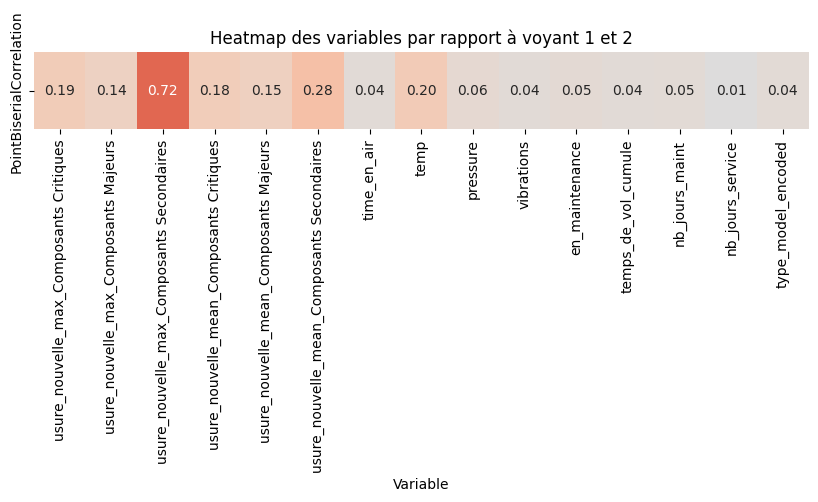

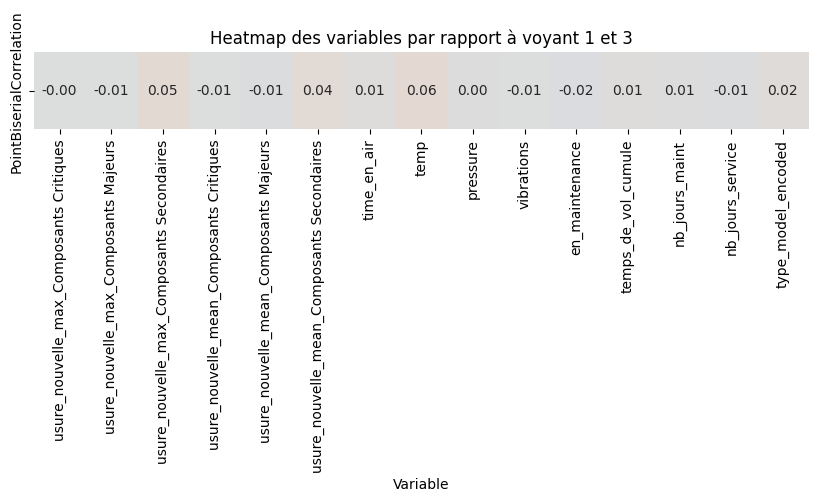

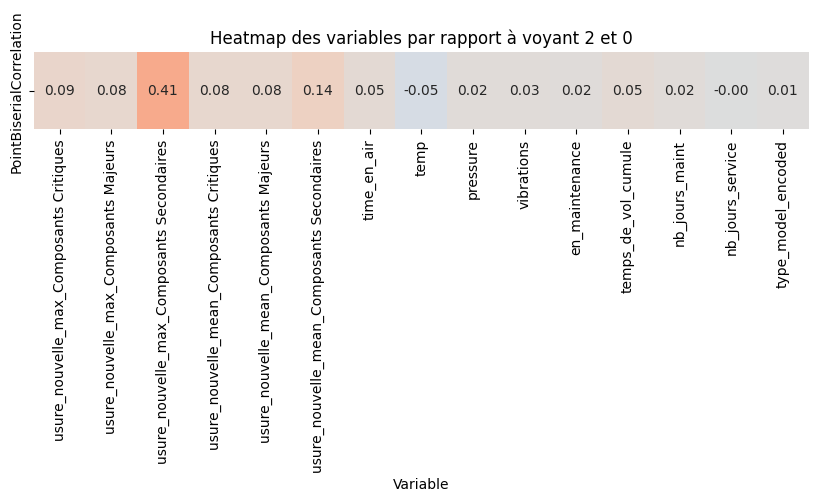

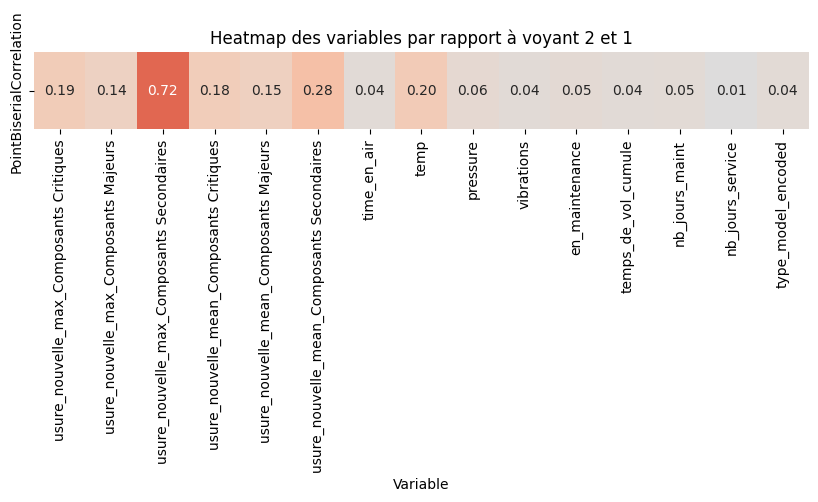

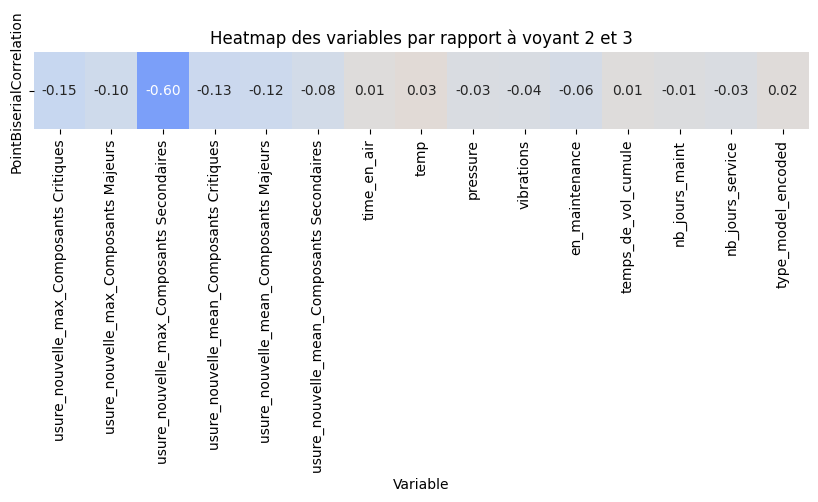

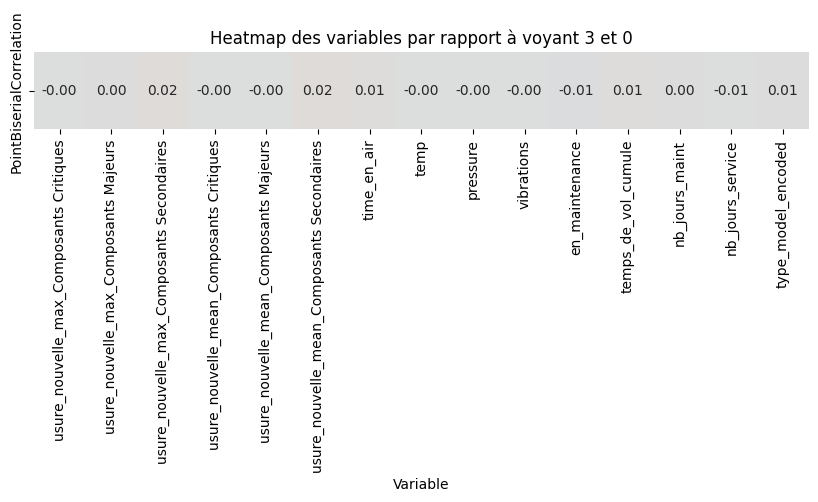

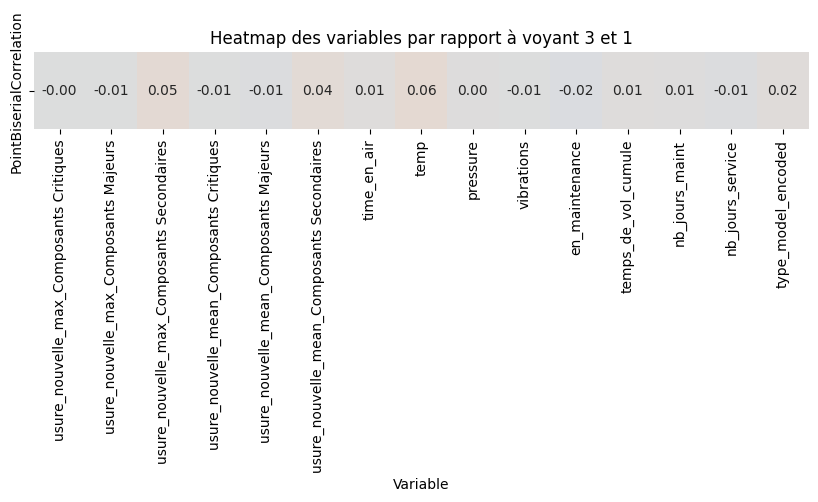

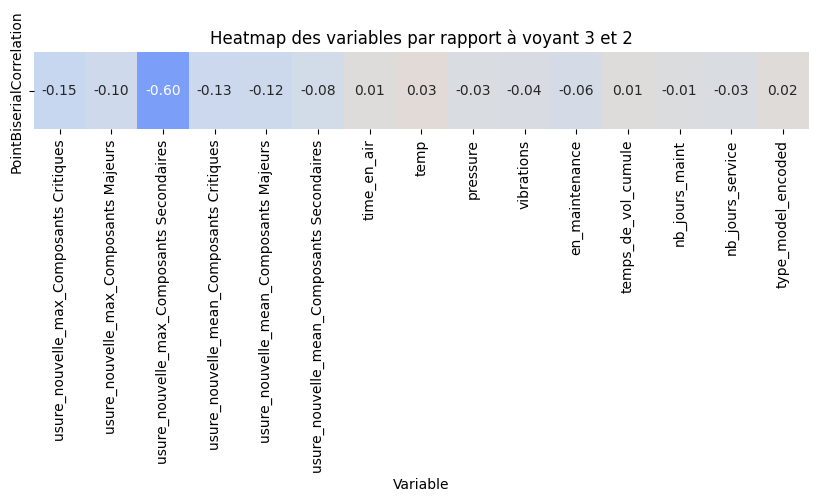

In [628]:
# encodage 0 ou 1 pour la class etat_voyant trié à 3

label_encoder = LabelEncoder()

for j in range(1, 4, 1):
    for i in range(0,4,1):

        if i!=j:

            df_3 = df[(df['etat_voyant']==i) | (df['etat_voyant']==j)].copy()


            df_3['etat_voyant_encoded'] = label_encoder.fit_transform(df_3['etat_voyant'])
            df_3['type_model_encoded'] = label_encoder.fit_transform(df_3['type_model'])

            df_3.drop(['etat_voyant', 'type_model', 'measure_day_'], axis=1, inplace=True)

            continuous_cols = df_3.drop(columns=['etat_voyant_encoded', 'aero_' ])


            # Calculer la corrélation bisériale ponctuelle pour chaque variable continue
            correlations = {}
            for col in continuous_cols.columns:

                correlations[col] = pointbiserialr(df_3['etat_voyant_encoded'], df_3[col])[0]

            # Convertir le dictionnaire en DataFrame pour la heatmap
            corr_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'PointBiserialCorrelation'])
            corr_df.set_index('Variable', inplace=True)

            # créer la figure
            plt.figure(figsize=(10, 1))

            sns.heatmap(corr_df.T, annot=True, cmap='coolwarm', cbar=False, fmt=".2f", vmin=-1, vmax= 1)
            plt.title(f'Heatmap des variables par rapport à voyant {j} et {i}')

            # Affichez la heatmap
            plt.show()

# 2- Prepa des données et pipeline pour ML

In [644]:
features_std = [
                     'usure_nouvelle_max_Composants Critiques',
                     'usure_nouvelle_max_Composants Majeurs',
                     'usure_nouvelle_max_Composants Secondaires',
                     'usure_nouvelle_mean_Composants Critiques',
                     'usure_nouvelle_mean_Composants Majeurs',
                     'usure_nouvelle_mean_Composants Secondaires',
                     'temp', 'pressure', 'vibrations',
                     'temps_de_vol_cumule', 'nb_jours_maint',
                     'nb_jours_service'
]

features_oneHot = ['type_model',
                   'en_maintenance']

In [630]:
# Préparation des transformateurs pour les caractéristiques numériques
numeric_transformer_std = (ImbPipeline( steps= [
    ('stdScaller', StandardScaler())
]))

categ_transformer_onehot = (ImbPipeline( steps= [
    ('OneHot', OneHotEncoder())
]))


# Combinaison des transformation pour le preprocessing
preprocessor = ColumnTransformer(
    transformers= [
        ('num_std', numeric_transformer_std, features_std),
        ('cat_oneHot', categ_transformer_onehot, features_oneHot)
    ]
)

In [631]:
y = df['etat_voyant'] 

X = df[['usure_nouvelle_max_Composants Critiques',
        'usure_nouvelle_max_Composants Majeurs',
        'usure_nouvelle_max_Composants Secondaires',
        'usure_nouvelle_mean_Composants Critiques',
        'usure_nouvelle_mean_Composants Majeurs',
        'usure_nouvelle_mean_Composants Secondaires',
        'temp', 'pressure', 'vibrations',
        'temps_de_vol_cumule', 'nb_jours_maint',
        'nb_jours_service', 'type_model',
        'en_maintenance']]

In [632]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

# 3- Essai de modele

## 3.1- Logistic regression

In [633]:
RL_model = XGBClassifier()

In [634]:
pipeline_reg_log = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('model', RL_model)
])

In [635]:
param_dist_xgbc = {
    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bynode': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__min_child_weight': [1, 2, 3, 4, 5, 6],
    'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'model__reg_lambda': [1, 0.1, 0.01, 0.001, 0],
    'model__eval_metric': ['mlogloss', 'logloss'],
}


In [636]:
random_search_xgbc = RandomizedSearchCV(
    estimator=pipeline_reg_log,
    param_distributions=param_dist_xgbc,
    n_iter=20,  # Number of iterations reduced to make it manageable
    scoring='accuracy',
    verbose=1,
    random_state=42,
    cv=5,
    n_jobs=-1  # Use all available cores
)

In [637]:
random_search_xgbc.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
80 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_std',
                                                                               Pipeline(steps=[('stdScaller',
                                                                                                StandardScaler())]),
                                                                               ['usure_nouvelle_max_Composants '
                                                                                'Critiques',
                                                                                'usure_nouvelle_max_Composants '
                                                                                'Majeurs',
                                                                                'usure_nouvelle_max_Composants '
                                                                                'Secondaires',
                                                                                'usure_nouvelle_mean_Composants '
                                                                                'Critiques',
                                                                                'usure_nouvelle_m...
                                                         0.5],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2, 0.3,
                                                                 0.4],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_child_weight': [1, 2, 3, 4,
                                                                    5, 6],
                                        'model__n_estimators': [50, 100, 200,
                                                                300, 400, 500],
                                        'model__reg_alpha': [0, 0.01, 0.1, 1,
                                                             10],
                                        'model__reg_lambda': [1, 0.1, 0.01,
                                                              0.001, 0],
                                        'model__subsample': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [638]:
# Afficher les meilleurs paramètres trouvés
print("Best parameters found: ", random_search_xgbc.best_params_)

# Évaluer le modèle sur l'ensemble de test
best_model_xgbc = random_search_xgbc.best_estimator_

Best parameters found:  {'model__subsample': 0.7, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.1, 'model__n_estimators': 300, 'model__min_child_weight': 5, 'model__max_depth': 9, 'model__learning_rate': 0.2, 'model__gamma': 0.5, 'model__eval_metric': 'logloss', 'model__colsample_bytree': 0.8, 'model__colsample_bynode': 0.9, 'model__colsample_bylevel': 0.9}


In [639]:
y_pred_rl = best_model_xgbc.predict(X_test)

In [640]:
accuracy_rl = accuracy_score(y_test, y_pred_rl)

print(f'Accuracy: {accuracy_rl:.4f}')

Accuracy: 0.9880


In [641]:
class_report_rl = classification_report(y_test, y_pred_rl)

print(class_report_rl)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1056
           1       0.97      0.96      0.97       169
           2       0.87      0.96      0.92        28
           3       0.00      0.00      0.00         1

    accuracy                           0.99      1254
   macro avg       0.71      0.73      0.72      1254
weighted avg       0.99      0.99      0.99      1254



c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

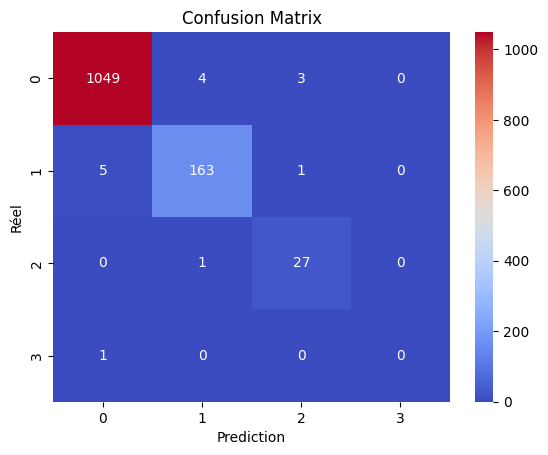

In [642]:
conf_matrix_rl = confusion_matrix(y_test, y_pred_rl)

sns.heatmap(conf_matrix_rl, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Réel')

plt.title('Confusion Matrix')
plt.show()

# 3- Enregistrement du modele

In [643]:

# Enregistrer le modèle dans un fichier
joblib.dump(best_model_xgbc, 'best_model_avion.pkl')

['best_model_avion.pkl']